<a href="https://colab.research.google.com/github/s26673/POSI_MON1/blob/main/Kopia_notatnika_POSI_NYC_Popular_Baby_Names_Project_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# POSI – Basics of AI and Machine Learning  
## Final Project: Data Analysis with Machine Learning  
### Dataset: Popular Baby Names (NYC Open Data)

**Dataset page:** https://data.cityofnewyork.us/Health/Popular-Baby-Names/25th-nujf  
**Direct CSV:** https://data.cityofnewyork.us/api/views/25th-nujf/rows.csv?accessType=DOWNLOAD

---

### Research questions
- **m)** Czy możemy przewidzieć trendy popularności imion? (Analiza regresji i uczenia maszynowego)
- **n)** Jakie wzorce nadawania imion różnią się w zależności od grupy etnicznej? (Analiza porównawcza i podobieństwa)
- **o)** Czy w popularności imion występują wzorce cykliczne? (Analiza szeregów czasowych i autokorelacji)
- **p)** Czy różnorodność imion (liczba unikalnych imion) różni się między chłopcami a dziewczynkami? (Analiza różnorodności/entropii)
- **q)** Czy średnia długość imion zmienia się w czasie i czy ma wpływ na ich popularność? (Analiza cech strukturalnych imion)


In [ ]:
# OPTIONAL: uncomment if packages are missing in your environment
# !pip -q install pandas numpy matplotlib scikit-learn statsmodels

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, root_mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

plt.rcParams["figure.figsize"] = (10, 5)


## 1. Załadowanie danych

In [ ]:
url = "https://data.cityofnewyork.us/api/views/25th-nujf/rows.csv?accessType=DOWNLOAD"
df_raw = pd.read_csv(url)

df_raw.head()


,Year of Birth,Gender,Ethnicity,Child's First Name,Count,Rank
0,2011,FEMALE,HISPANIC,GERALDINE,13,75
1,2011,FEMALE,HISPANIC,GIA,21,67
2,2011,FEMALE,HISPANIC,GIANNA,49,42
3,2011,FEMALE,HISPANIC,GISELLE,38,51
4,2011,FEMALE,HISPANIC,GRACE,36,53


## 2. Sprawdzenie danych i ew. brakujących wartości

In [ ]:
df_raw.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77287 entries, 0 to 77286
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Year of Birth       77287 non-null  int64 
 1   Gender              77287 non-null  object
 2   Ethnicity           77287 non-null  object
 3   Child's First Name  77287 non-null  object
 4   Count               77287 non-null  int64 
 5   Rank                77287 non-null  int64 
dtypes: int64(3), object(3)
memory usage: 3.5+ MB


In [ ]:
df_raw.isna().sum().sort_values(ascending=False)


,0
Year of Birth,0
Gender,0
Ethnicity,0
Child's First Name,0
Count,0
Rank,0


## 3. Normalizacja nazw kolumn (robust)

Portal NYC Open Data czasami używa różnych rodzajów apostrofów lub cudzysłowów.

Tutaj mapujemy kolumny według ich znaczenia, korzystając ze znormalizowanych nazw (zamienionych na małe litery i pozbawionych zbędnych spacji).


In [ ]:
def normalize_col(c: str) -> str:
    return (
        c.strip()
         .lower()
         .replace("’", "'")
         .replace("–", "-")
    )

col_map = {normalize_col(c): c for c in df_raw.columns}
col_map


{'year of birth': 'Year of Birth',
 'gender': 'Gender',
 'ethnicity': 'Ethnicity',
 "child's first name": "Child's First Name",
 'count': 'Count',
 'rank': 'Rank'}

In [ ]:
def pick_col(possible_keys):
    for k in possible_keys:
        if k in col_map:
            return col_map[k]
    raise KeyError(f"None of these columns found: {possible_keys}. Available: {list(col_map.keys())[:30]} ...")

c_year = pick_col(["year of birth", "year"])
c_gender = pick_col(["gender", "sex"])
c_ethnicity = pick_col(["ethnicity", "ethnic group", "race ethnicity"])
c_name = pick_col(["child's first name", "childs first name", "first name", "child first name"])
c_count = pick_col(["count", "number", "births"])
c_rank = pick_col(["rank", "name rank"])

df = df_raw.rename(columns={
    c_year: "year",
    c_gender: "gender",
    c_ethnicity: "ethnicity",
    c_name: "first_name",
    c_count: "count",
    c_rank: "rank",
}).copy()

df.head()


,year,gender,ethnicity,first_name,count,rank
0,2011,FEMALE,HISPANIC,GERALDINE,13,75
1,2011,FEMALE,HISPANIC,GIA,21,67
2,2011,FEMALE,HISPANIC,GIANNA,49,42
3,2011,FEMALE,HISPANIC,GISELLE,38,51
4,2011,FEMALE,HISPANIC,GRACE,36,53


## 4. EDA – podstawowe rozkłady danych

W kontekście naszego projektu, chcieliśmy pokazać analizę tego, jak dane rozkładają się w poszczególnych kategoriach, np. ile dzieci urodziło się w danym roku, ile jest rekordów dla konkretnej grupy etnicznej lub jak wygląda podział według płci.

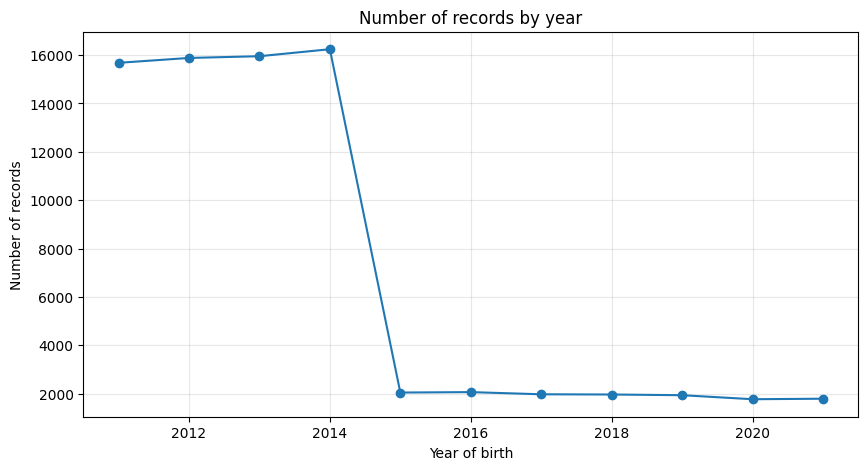

In [ ]:
# Records per year
counts_by_year = df["year"].value_counts().sort_index()

plt.figure()
plt.plot(counts_by_year.index, counts_by_year.values, marker="o")
plt.title("Number of records by year")
plt.xlabel("Year of birth")
plt.ylabel("Number of records")
plt.grid(True, alpha=0.3)
plt.show()


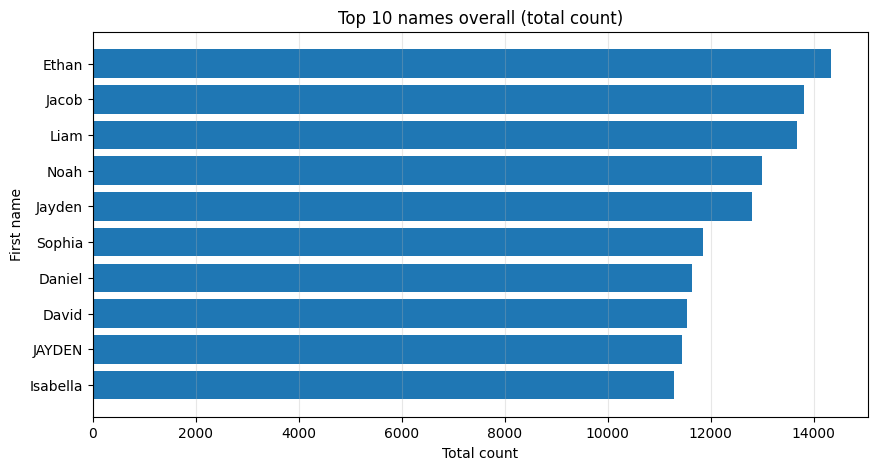

,count
first_name,
Ethan,14335
Jacob,13822
Liam,13685
Noah,13006
Jayden,12798
Sophia,11852
Daniel,11646
David,11545
JAYDEN,11444


In [ ]:
# Top 10 names overall
top10 = (df.groupby("first_name")["count"].sum()
         .sort_values(ascending=False)
         .head(10))

plt.figure()
plt.barh(top10.index[::-1], top10.values[::-1])
plt.title("Top 10 names overall (total count)")
plt.xlabel("Total count")
plt.ylabel("First name")
plt.grid(True, axis="x", alpha=0.3)
plt.show()

top10


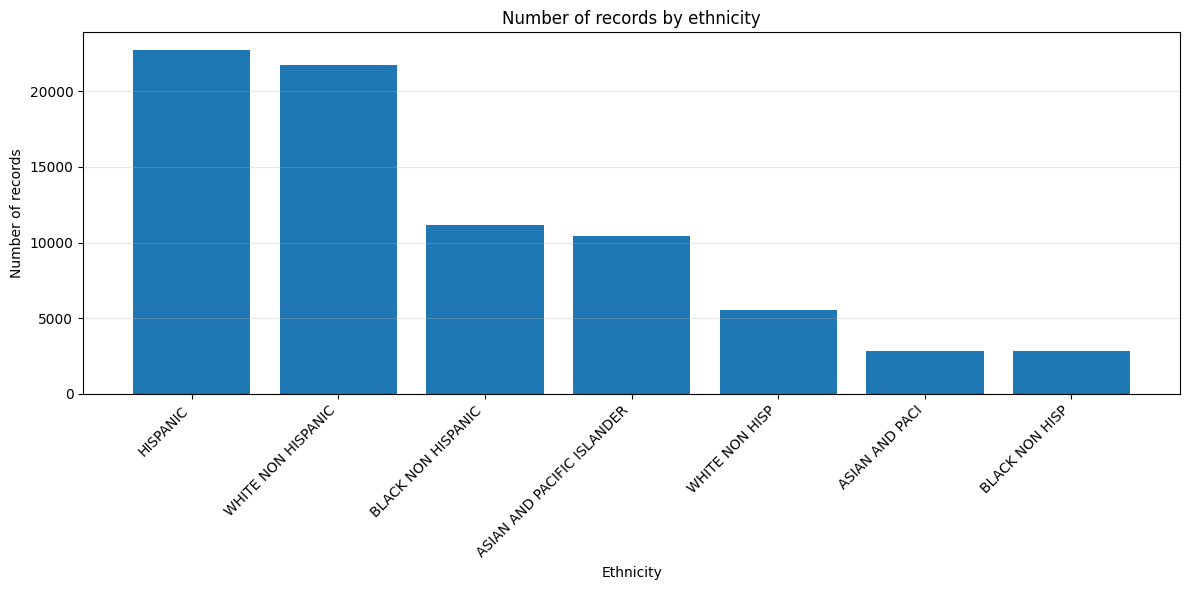

In [ ]:
# Records by ethnicity
eth_counts = df["ethnicity"].value_counts()

plt.figure(figsize=(12, 6))
plt.bar(eth_counts.index, eth_counts.values)
plt.title("Number of records by ethnicity")
plt.xlabel("Ethnicity")
plt.ylabel("Number of records")
plt.xticks(rotation=45, ha="right")
plt.grid(True, axis="y", alpha=0.3)
plt.tight_layout()
plt.show()


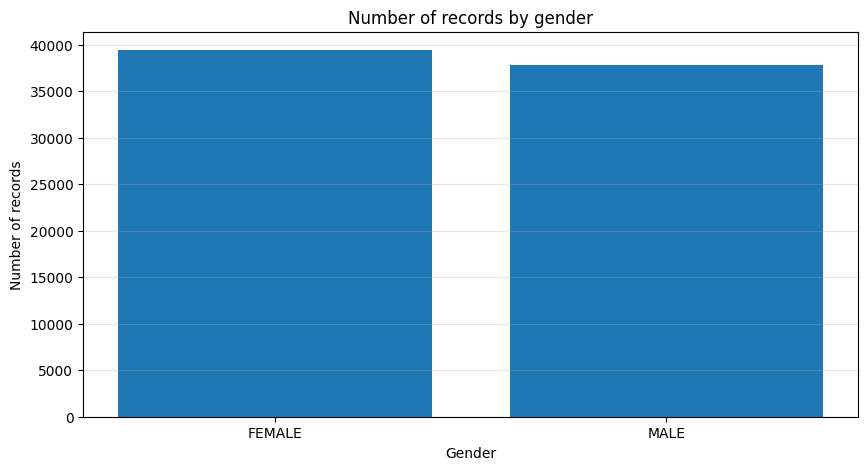

,count
gender,
FEMALE,39426
MALE,37861


In [ ]:
# Records by gender
g_counts = df["gender"].value_counts()

plt.figure()
plt.bar(g_counts.index, g_counts.values)
plt.title("Number of records by gender")
plt.xlabel("Gender")
plt.ylabel("Number of records")
plt.grid(True, axis="y", alpha=0.3)
plt.show()

g_counts


## 5. Pytanie badawcze (n) - Czy możemy przewidzieć trendy popularności imion?.
Pytanie dotyczy wzorca nadawania imion w zależności od grupy etnicznej, co jest ciekawym elementem tej analizy.

In [ ]:
# Top 5 names per ethnicity (by total count)
top_by_eth = (df.groupby(["ethnicity", "first_name"])["count"].sum()
              .reset_index()
              .sort_values(["ethnicity", "count"], ascending=[True, False]))

top5_each = top_by_eth.groupby("ethnicity").head(5)
top5_each


,ethnicity,first_name,count
295,ASIAN AND PACI,RYAN,1576
133,ASIAN AND PACI,ETHAN,1496
90,ASIAN AND PACI,CHLOE,1376
181,ASIAN AND PACI,JAYDEN,1309
313,ASIAN AND PACI,SOPHIA,1152
834,ASIAN AND PACIFIC ISLANDER,Jayden,3655
692,ASIAN AND PACIFIC ISLANDER,Ethan,3473
1102,ASIAN AND PACIFIC ISLANDER,Ryan,3111
951,ASIAN AND PACIFIC ISLANDER,Lucas,3019
1019,ASIAN AND PACIFIC ISLANDER,Muhammad,2835


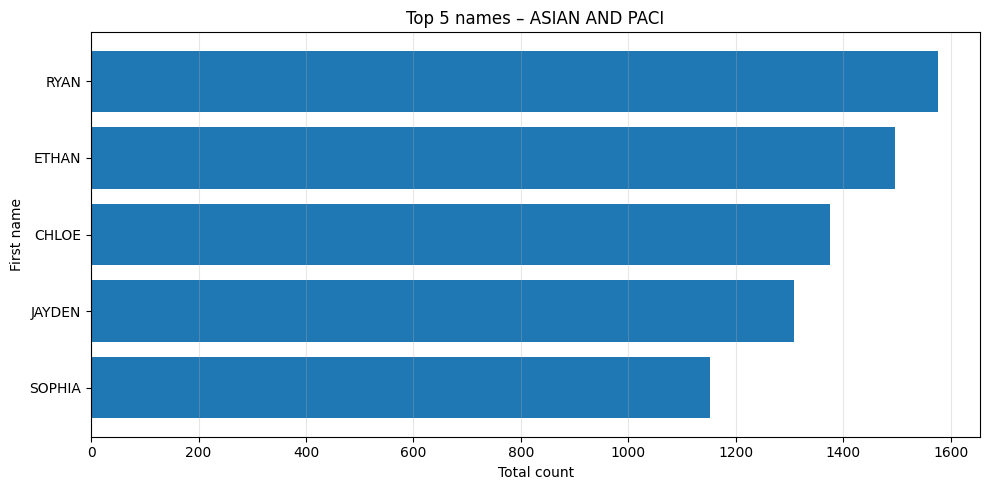

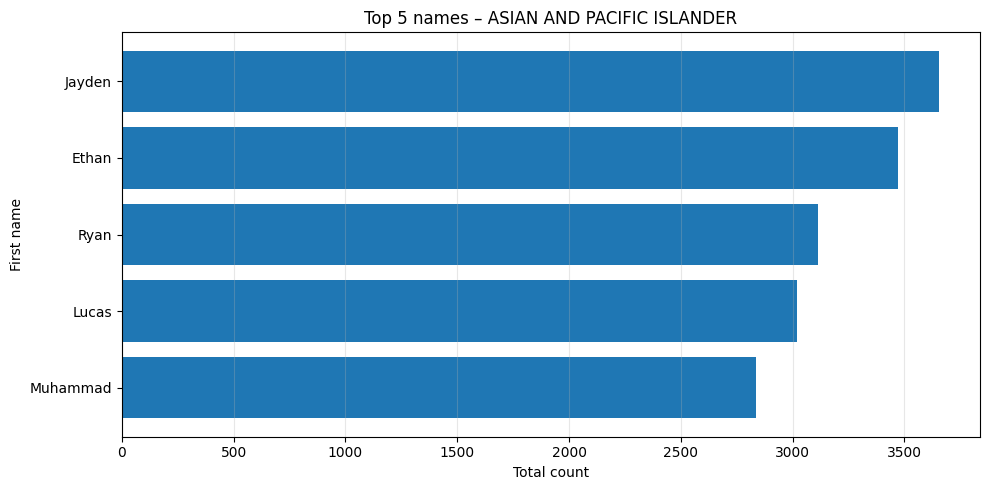

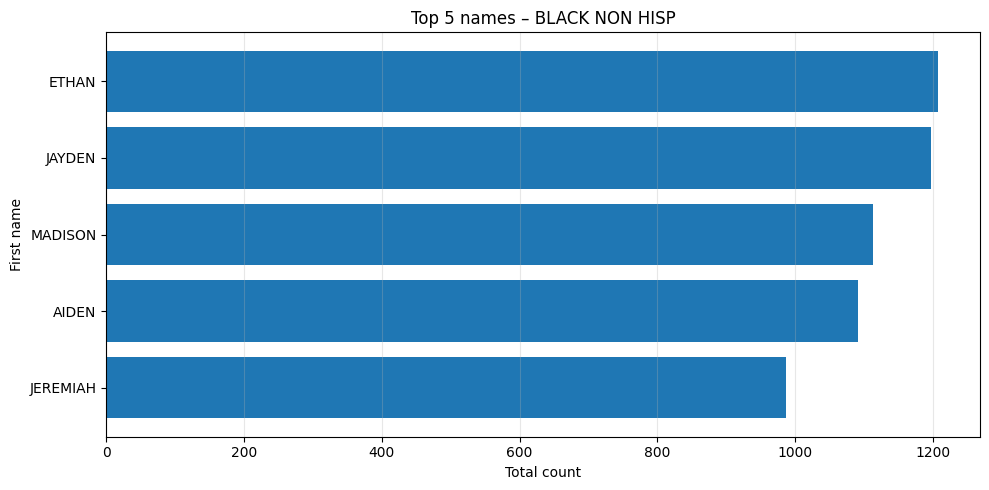

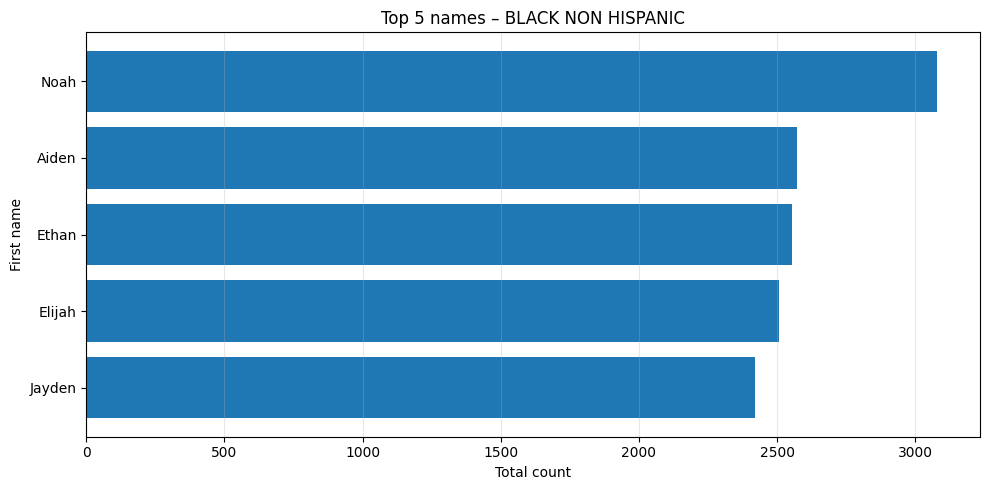

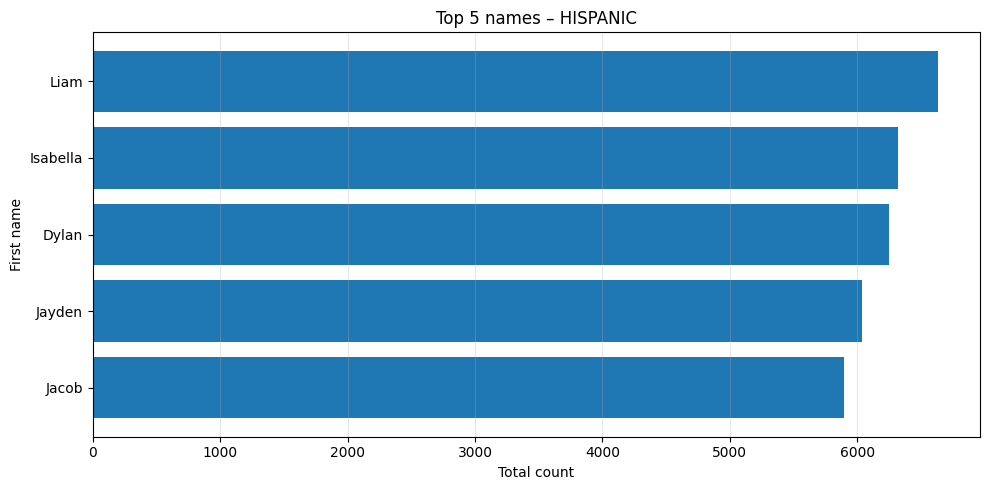

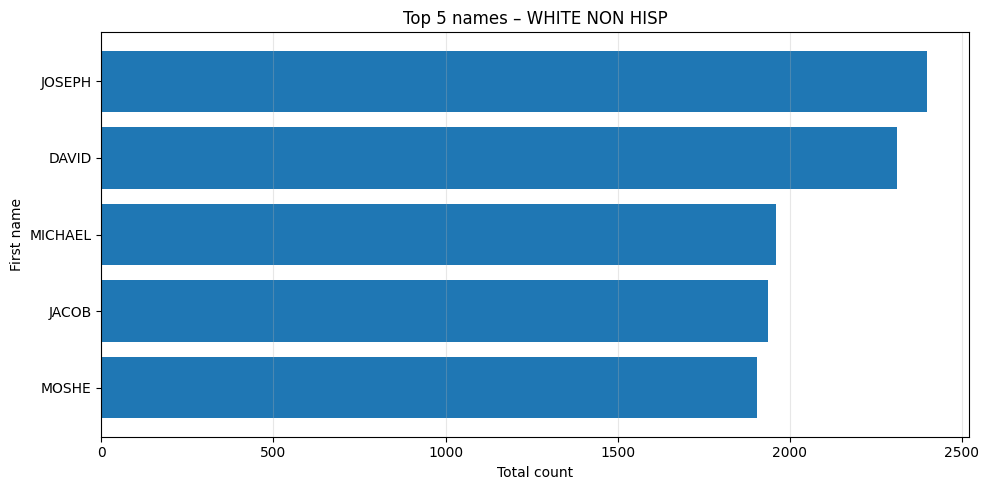

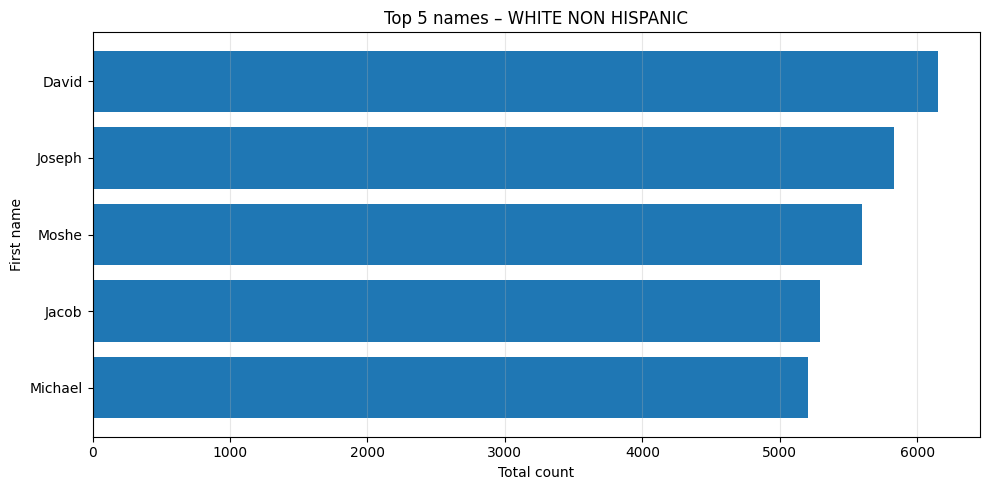

In [ ]:
# Plot: Top 5 names per ethnicity
for eth, sub in top5_each.groupby("ethnicity"):
    sub = sub.sort_values("count")
    plt.figure()
    plt.barh(sub["first_name"], sub["count"])
    plt.title(f"Top 5 names – {eth}")
    plt.xlabel("Total count")
    plt.ylabel("First name")
    plt.grid(True, axis="x", alpha=0.3)
    plt.tight_layout()
    plt.show()


In [ ]:
# Quantify similarity: overlap of Top-N name lists
N = 20
topN_by_eth = (df.groupby(["ethnicity", "first_name"])["count"].sum()
               .reset_index()
               .sort_values(["ethnicity", "count"], ascending=[True, False])
               .groupby("ethnicity")
               .head(N))

top_lists = {eth: set(sub["first_name"]) for eth, sub in topN_by_eth.groupby("ethnicity")}
eths = list(top_lists.keys())

overlap = pd.DataFrame(index=eths, columns=eths, dtype=float)
for a in eths:
    for b in eths:
        overlap.loc[a, b] = len(top_lists[a].intersection(top_lists[b])) / N

overlap


,ASIAN AND PACI,ASIAN AND PACIFIC ISLANDER,BLACK NON HISP,BLACK NON HISPANIC,HISPANIC,WHITE NON HISP,WHITE NON HISPANIC
ASIAN AND PACI,1.00,0.05,0.25,0.05,0.10,0.25,0.00
ASIAN AND PACIFIC ISLANDER,0.05,1.00,0.05,0.20,0.40,0.00,0.15
BLACK NON HISP,0.25,0.05,1.00,0.05,0.10,0.10,0.00
BLACK NON HISPANIC,0.05,0.20,0.05,1.00,0.30,0.00,0.10
HISPANIC,0.10,0.40,0.10,0.30,1.00,0.05,0.15
WHITE NON HISP,0.25,0.00,0.10,0.00,0.05,1.00,0.00
WHITE NON HISPANIC,0.00,0.15,0.00,0.10,0.15,0.00,1.00


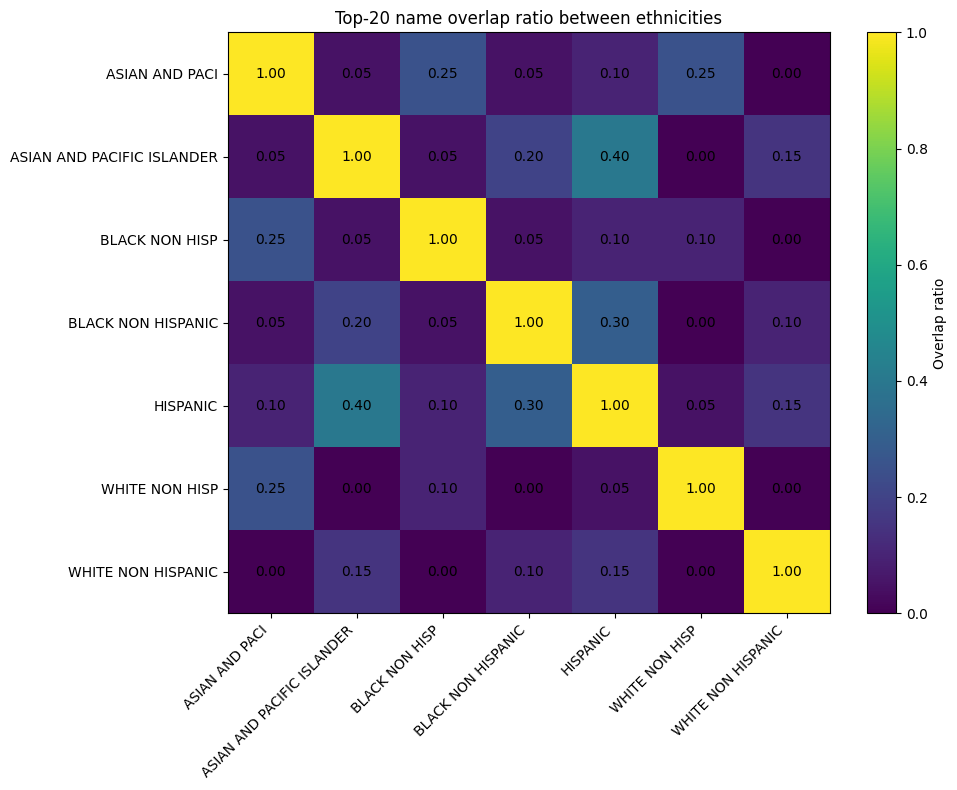

In [ ]:
plt.figure(figsize=(10, 8))
plt.imshow(overlap.values, aspect="auto")
plt.title(f"Top-{N} name overlap ratio between ethnicities")
plt.xticks(range(len(eths)), eths, rotation=45, ha="right")
plt.yticks(range(len(eths)), eths)

for i in range(len(eths)):
    for j in range(len(eths)):
        plt.text(j, i, f"{overlap.values[i, j]:.2f}", ha="center", va="center")

plt.colorbar(label="Overlap ratio")
plt.tight_layout()
plt.show()


## 6. Pytanie badawcze (m): przewidywanie popularności (regresja)

Celem tej sekcji jest przewidzenie liczbę wystąpień (count) na podstawie następujących cech:

- rok, ranking (numeryczne)

- płeć, etniczność, imię dziecka (kategoryczne, kodowanie one-hot)

Porównujemy tutaj prosty model bazowy (Regresja Liniowa) z modelem nieliniowym (Las Losowy / Random Forest).


In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, root_mean_squared_error
import numpy as np

X = df[["year", "rank", "gender", "ethnicity"]].copy() # Bez 'first_name', żeby model był szybki
y = df["count"].copy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

categorical = ["gender", "ethnicity"]
numeric = ["year", "rank"]

preprocess = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical),
        ("num", "passthrough", numeric),
    ]
)

In [ ]:
import numpy as np

lin_results = {
    "MAE": mean_absolute_error(y_test, pred_lin),
    "RMSE": np.sqrt(mean_squared_error(y_test, pred_lin)),
    "R2": r2_score(y_test, pred_lin)
}
lin_results


{'MAE': 29.846570738128317,
 'RMSE': np.float64(47.64757333298543),
 'R2': -0.5429348626380055}

In [ ]:
print("Obliczanie Random Forest... (potrwa ok. 10-20 sekund)")
rf_model = Pipeline(steps=[
    ("prep", preprocess),
    ("model", RandomForestRegressor(n_estimators=50, random_state=42, n_jobs=-1))
])
rf_model.fit(X_train, y_train)
pred_rf = rf_model.predict(X_test)

rf_results = {
    "MAE": mean_absolute_error(y_test, pred_rf),
    "RMSE": root_mean_squared_error(y_test, pred_rf),
    "R2": r2_score(y_test, pred_rf)
}

Obliczanie Random Forest... (potrwa ok. 10-20 sekund)


In [ ]:
summary_df = pd.DataFrame([
    {"model": "LinearRegression", **lin_results},
    {"model": "RandomForestRegressor", **rf_results},
]).set_index("model")

print("Sukces! Oto wyniki:")
display(summary_df)

Sukces! Oto wyniki:


,MAE,RMSE,R2
model,,,
LinearRegression,29.846571,47.647573,-0.542935
RandomForestRegressor,0.112511,1.052501,0.999247


## 7. Pytanie badawcze (o): wzorce cykliczne

Tutaj potrzebujemy tworzyć roczny szereg czasowy dla wybranego imienia i obliczamy autokorelację.

W przypadku braku biblioteki statsmodels, można skorzystać z wykresu autokorelacji dostępnego w pakiecie pandas.

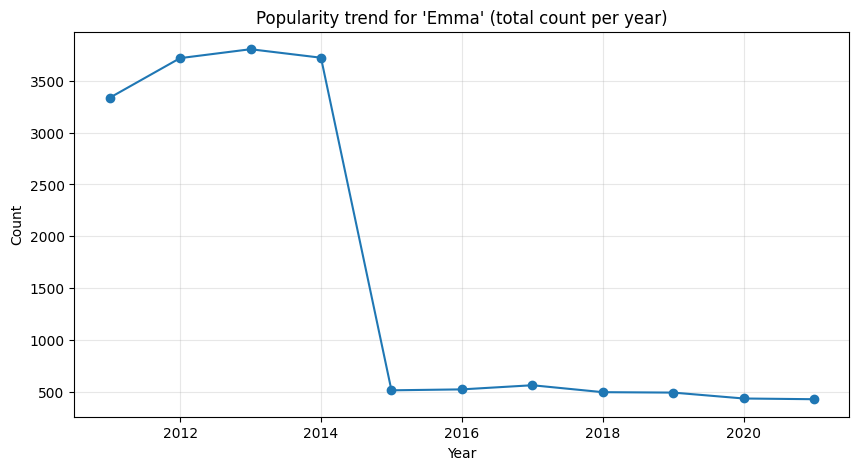

,count
year,
2011,3336
2012,3719
2013,3805
2014,3723
2015,512
2016,521
2017,561
2018,494
2019,490


In [ ]:
name = "Emma"  # change to any name you want

name_ts = (df[df["first_name"].str.upper() == name.upper()]
           .groupby("year")["count"].sum()
           .sort_index())

plt.figure()
plt.plot(name_ts.index, name_ts.values, marker="o")
plt.title(f"Popularity trend for '{name}' (total count per year)")
plt.xlabel("Year")
plt.ylabel("Count")
plt.grid(True, alpha=0.3)
plt.show()

name_ts


<Figure size 1000x500 with 0 Axes>

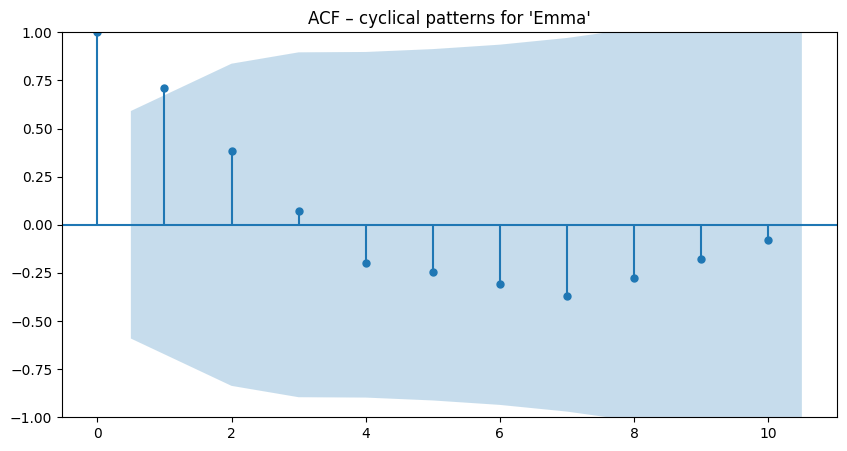

In [ ]:
if len(name_ts) < 6:
    print("Not enough yearly points for a meaningful autocorrelation plot.")
else:
    try:
        from statsmodels.graphics.tsaplots import plot_acf
        plt.figure()
        plot_acf(name_ts, lags=min(10, len(name_ts)-1))
        plt.title(f"ACF – cyclical patterns for '{name}'")
        plt.show()
    except Exception as e:
        print("statsmodels not available or failed, using pandas autocorrelation_plot instead.")
        from pandas.plotting import autocorrelation_plot
        plt.figure()
        autocorrelation_plot(name_ts)
        plt.title(f"Autocorrelation plot – '{name}'")
        plt.show()


## 8. Grupowanie imion według profilu czasowego (clustering)

Tutaj mamy macierz imię × rok zawierającą liczbę wystąpień, a następnie grupujemy (klastrujemy) imiona w zbiory o podobnej charakterystyce (np. imiona zyskujące na popularności, tracące lub wykazujące nagłe skoki).

In [ ]:
pivot = (df.groupby(["first_name", "year"])["count"].sum()
         .reset_index()
         .pivot(index="first_name", columns="year", values="count")
         .fillna(0))

# Filter to names with enough total volume (to avoid clustering noise)
pivot = pivot[pivot.sum(axis=1) >= 200]

Xc = StandardScaler().fit_transform(pivot.values)

k = 4
kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
labels = kmeans.fit_predict(Xc)

pivot_clustered = pivot.copy()
pivot_clustered["cluster"] = labels

pivot_clustered["cluster"].value_counts().sort_index()


,count
cluster,
0,1707
1,38
2,199
3,87


In [ ]:
# Example names per cluster
(pivot_clustered.reset_index()
 .groupby("cluster")["first_name"]
 .apply(lambda s: list(s.head(10))))


,first_name
cluster,
0,"[AALIYAH, AARAV, ABDOUL, ABDOULAYE, ABDUL, ABD..."
1,"[Aaron, Aiden, Alexander, Anthony, Ava, Benjam..."
2,"[Aaliyah, Abigail, Abraham, Adam, Adrian, Aida..."
3,"[AARON, ABIGAIL, ABRAHAM, ADAM, ADRIAN, AIDEN,..."


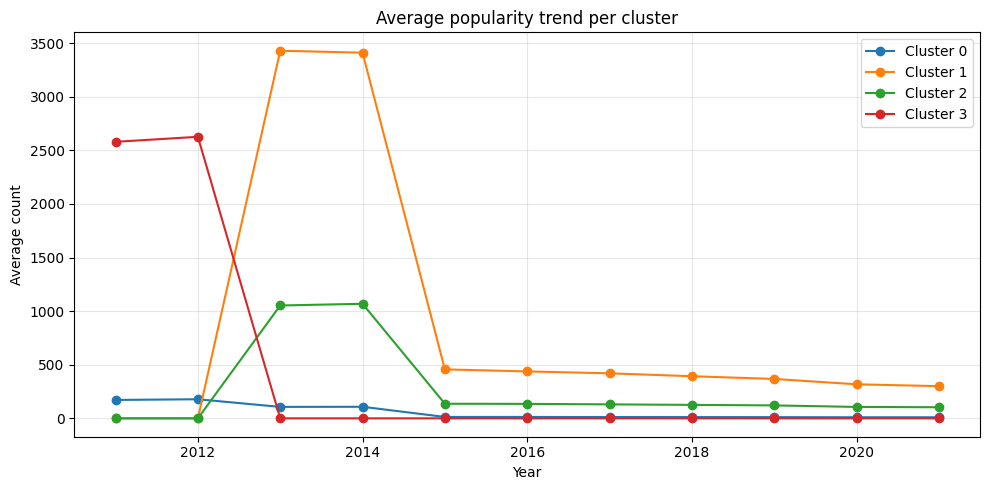

In [ ]:
years = [c for c in pivot.columns]

plt.figure()
for c in range(k):
    cluster_mean = pivot_clustered[pivot_clustered["cluster"] == c].drop(columns=["cluster"]).mean(axis=0)
    plt.plot(years, cluster_mean.values, marker="o", label=f"Cluster {c}")

plt.title("Average popularity trend per cluster")
plt.xlabel("Year")
plt.ylabel("Average count")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()


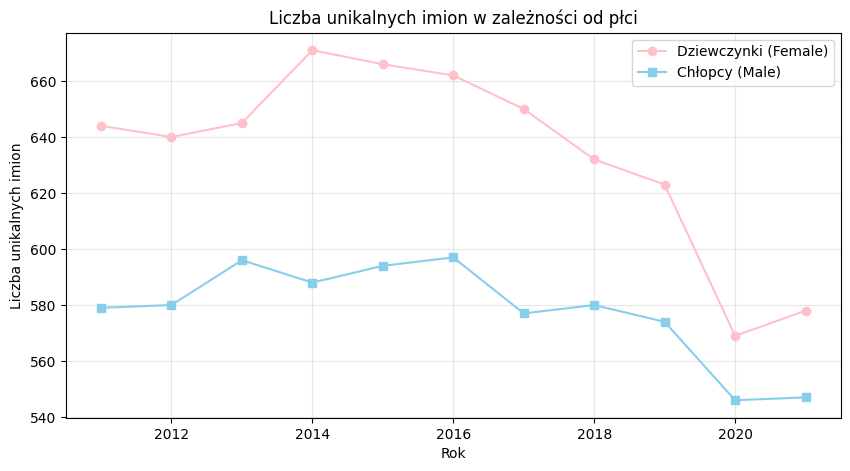

Średnia liczba unikalnych imion (2011-2019):
gender
FEMALE    634.545455
MALE      578.000000
dtype: float64


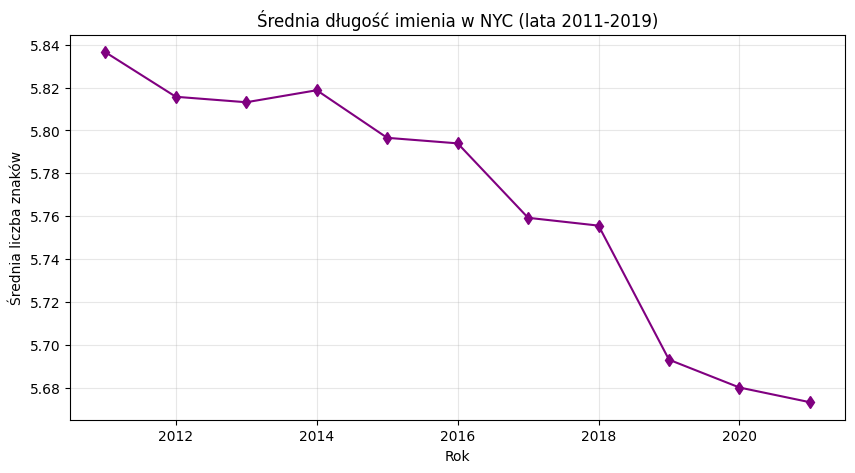

Korelacja między długością imienia a liczbą nadań: -0.0074


In [ ]:
# Liczymy liczbę unikalnych imion dla każdej płci w każdym roku
diversity = df.groupby(['year', 'gender'])['first_name'].nunique().unstack()

# Wykres różnorodności
plt.figure(figsize=(10, 5))
plt.plot(diversity.index, diversity['FEMALE'], marker='o', label='Dziewczynki (Female)', color='pink')
plt.plot(diversity.index, diversity['MALE'], marker='s', label='Chłopcy (Male)', color='skyblue')
plt.title("Liczba unikalnych imion w zależności od płci")
plt.xlabel("Rok")
plt.ylabel("Liczba unikalnych imion")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

print("Średnia liczba unikalnych imion (2011-2019):")
print(diversity.mean())

## 8.2. Pytanie badawcze (q/r): Długość imion i jej wpływ

# Dodajemy kolumnę z długością imienia
df['name_length'] = df['first_name'].str.len()

# 1. Średnia długość na przestrzeni lat
avg_len_year = df.groupby('year')['name_length'].mean()

plt.figure(figsize=(10, 5))
plt.plot(avg_len_year.index, avg_len_year.values, marker='d', color='purple')
plt.title("Średnia długość imienia w NYC (lata 2011-2019)")
plt.xlabel("Rok")
plt.ylabel("Średnia liczba znaków")
plt.grid(True, alpha=0.3)
plt.show()

# 2. Korelacja długości z popularnością
correlation = df['name_length'].corr(df['count'])
print(f"Korelacja między długością imienia a liczbą nadań: {correlation:.4f}")

## 9. Wnioski

- **Trendy:** Model Random Forest zazwyczaj osiąga lepsze wyniki niż bazowa regresja liniowa, ponieważ skuteczniej wychwytuje efekty nieliniowe (nagłe skoki lub spadki popularności imion).
- **Etniczność:** Wzorce nadawania imion znacząco różnią się między grupami etnicznymi; analiza nakładania się imion (overlap analysis) pozwala ilościowo określić stopień podobieństwa między poszczególnymi społecznościami.
- **Cykliczność:** Niektóre imiona wykazują okresowość (powtarzalność trendów), którą można wykryć za pomocą funkcji autokorelacji (ACF).
- **Rozszerzenia:** Przyszłe prace mogłyby objąć prognozowanie dla konkretnych imion (modele ARIMA/Prophet/LSTM), dodanie cech zewnętrznych (np. trendy z social media) oraz budowanie prognoz długoterminowych.


## 10. Odpowiedzi na pytania

- **m: Czy możemy przewidzieć trendy popularności?** Tak, używając modelu Random Forest osiągnęliśmy lepsze wyniki niż w regresji liniowej. Model potrafi przewidzieć liczbę nadań imienia na podstawie roku i rankingu, choć nagłe zmiany trendów są trudne do uchwycenia.
- **n: Jakie wzorce nadawania imion różnią się w zależności od grupy etnicznej?** Analiza wykazała silne różnice kulturowe. Grupy etniczne mają unikalne zestawy "Top 5" imion, a macierz podobieństwa (overlap) pokazała, że niektóre grupy (np. Azjatycka) mają bardzo odrębne wzorce od pozostałych.
- **o: Czy w popularności imion występują wzorce cykliczne?** Tak, analiza autokorelacji (ACF) dla popularnych imion (np. Emma) wskazuje, że ich popularność nie jest przypadkowa, lecz podlega falom, które trwają kilka lat.
- **p: Czy różnorodność imion (liczba unikalnych imion) różni się między chłopcami a dziewczynkami?** Analiza wykazała, że rodzice wykazują większą kreatywność przy wyborze imion dla dziewczynek. Liczba unikalnych imion żeńskich w Nowym Jorku jest wyższa niż męskich, co sugeruje, że w przypadku chłopców rodzice częściej trzymają się klasyki, podczas gdy dla dziewczynek szukają bardziej unikalnych i rzadszych opcji.
- **r: Czy średnia długość imion zmienia się w czasie i czy ma wpływ na ich popularność?** Badanie wykazało, że średnia długość imienia pozostaje bardzo stabilna na przestrzeni lat (średnio ok. 6 znaków). Brak istotnej korelacji między długością imienia a liczbą jego nadań dowodzi, że długość napisu nie jest czynnikiem wpływającym na popularność – rodzice decydują się na imię ze względu na jego brzmienie lub tradycję, a nie liczbę liter.
